# Data exploration

placeholder

In [28]:
# import required packages
# depending on your environment, you may need to install some of these
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import glob
import dask
import geopandas as gpd
import rasterio as rio
import datetime as dt
import pandas as pd
import math
import seaborn as sns

In [18]:
# open spicy dataset as xarray dataset
dask.config.set({"array.slicing.split_large_chunks": False})
ds = xr.open_mfdataset(glob.glob('./data/sd_2020-08-01_2021-07-31.nc'))

# drop s1 for compatibility with rioxarray, which requires three coordinates
ds = ds.drop_vars('band')
ds = ds.drop('s1')

# reproject dataset to utm zone
crs = ds.rio.estimate_utm_crs()
ds = ds.transpose('time', 'y', 'x')
ds = ds.rio.reproject(crs)

# open aoi geojson as geopandas dataframe and reproject
aoi_fn = './east_river_basin_wgs.geojson'
aoi_gdf = gpd.read_file(aoi_fn).to_crs(crs)

# clip dataset to aoi
ds = ds.rio.clip(aoi_gdf.geometry, crs=aoi_gdf.crs, drop=False)

In [19]:
# examine the dataset
ds

<xarray.Dataset>
Dimensions:         (x: 151, y: 178, time: 122)
Coordinates:
  * x               (x) float64 3.223e+05 3.224e+05 ... 3.366e+05 3.367e+05
  * y               (y) float64 4.322e+06 4.322e+06 ... 4.306e+06 4.306e+06
    flight_dir      (time) object 'descending' 'ascending' ... 'ascending'
    relative_orbit  (time) float64 56.0 151.0 129.0 49.0 ... 49.0 56.0 151.0
    platform        (time) object 'S1A' 'S1B' 'S1A' 'S1B' ... 'S1B' 'S1A' 'S1B'
    projection      int64 0
  * time            (time) datetime64[ns] 2020-08-02T13:09:50 ... 2021-07-29T...
    absolute_orbit  (time) float64 3.373e+04 2.275e+04 ... 3.898e+04 2.8e+04
    spatial_ref     int64 0
Data variables:
    ims             (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    fcf             (y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
    deltaCR         (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    deltaVV         (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    deltaGamma      (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    snow_index      (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    snow_depth      (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    wet_flag        (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    alt_wet_flag    (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    freeze_flag     (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    wet_snow        (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    perma_wet       (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
Attributes:
    AREA_OR_POINT:     Point
    TIFFTAG_DATETIME:  2023:05:06 20:19:16
    TIFFTAG_SOFTWARE:  Created with GAMMA Software www.gamma-rs.ch data2geoti...
    scale_factor:      1.0
    add_offset:        0.0
    resolution:        90
    s1_units:          dB

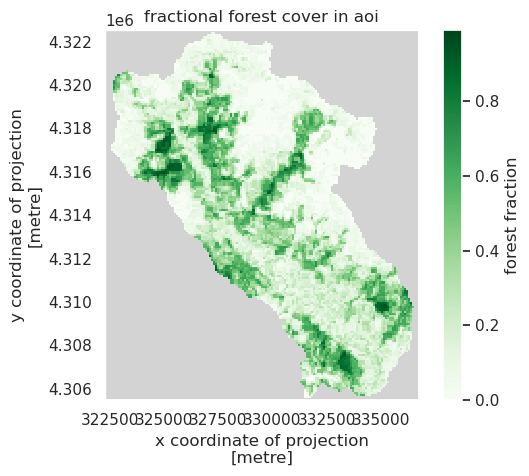

In [29]:
sns.set_theme()

# examine fractional forest cover for this site
f, ax = plt.subplots()
ds.fcf.plot(ax=ax, cmap='Greens', vmin=0, cbar_kwargs={'label':'forest fraction'})
ax.set_title('fractional forest cover in aoi')
ax.set_aspect('equal')
ax.add_patch(plt.Rectangle((0,0), 1, 1, facecolor='lightgray',
                                                 transform=ax.transAxes, zorder=-1))
plt.savefig('./figs/fcf.png', dpi=300)

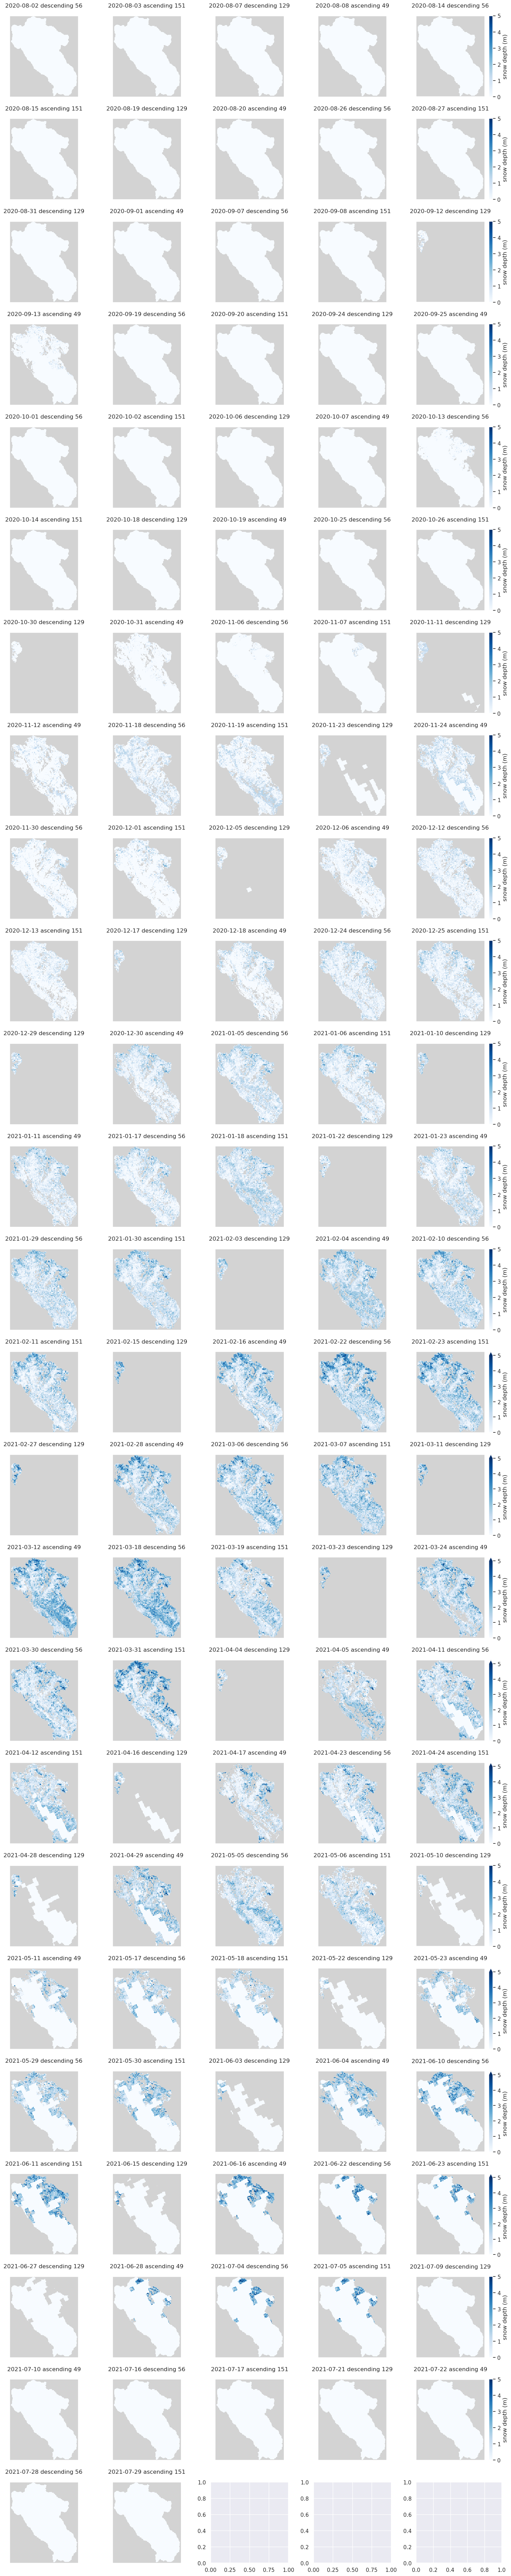

In [31]:
# plot all snow depth maps. This may take a minute
columns = 5
gridspec = {'width_ratios': [1, 1, 1, 1, 1.1]}
rows = math.ceil(len(ds.time)/columns)

f, ax = plt.subplots(rows, columns, figsize=(3*columns, 3*rows), gridspec_kw=gridspec)
for i, time in enumerate(ds.time):
    row_num = math.floor(i/columns)
    col_num = i%columns
    
    if col_num == columns-1:
        sd_map = ds.snow_depth.isel(time=i).plot(ax=ax[row_num, col_num], cmap='Blues', vmin=0, vmax=5, cbar_kwargs={'label':'snow depth (m)'})
    else: 
        sd_map = ds.snow_depth.isel(time=i).plot(ax=ax[row_num, col_num], cmap='Blues', vmin=0, vmax=5, add_colorbar=False)
    ax[row_num, col_num].set_aspect('equal')
    ax[row_num, col_num].set_title(time.dt.strftime('%Y-%m-%d').item()+f' {time.flight_dir.item()} {int(time.relative_orbit.item())}')
    ax[row_num, col_num].axis('off')
    ax[row_num, col_num].add_patch(plt.Rectangle((0,0), 1, 1, facecolor='lightgray',
                                                 transform=ax[row_num, col_num].transAxes, zorder=-1))
    
f.tight_layout()

plt.savefig('./figs/sd_maps.png', dpi=300)

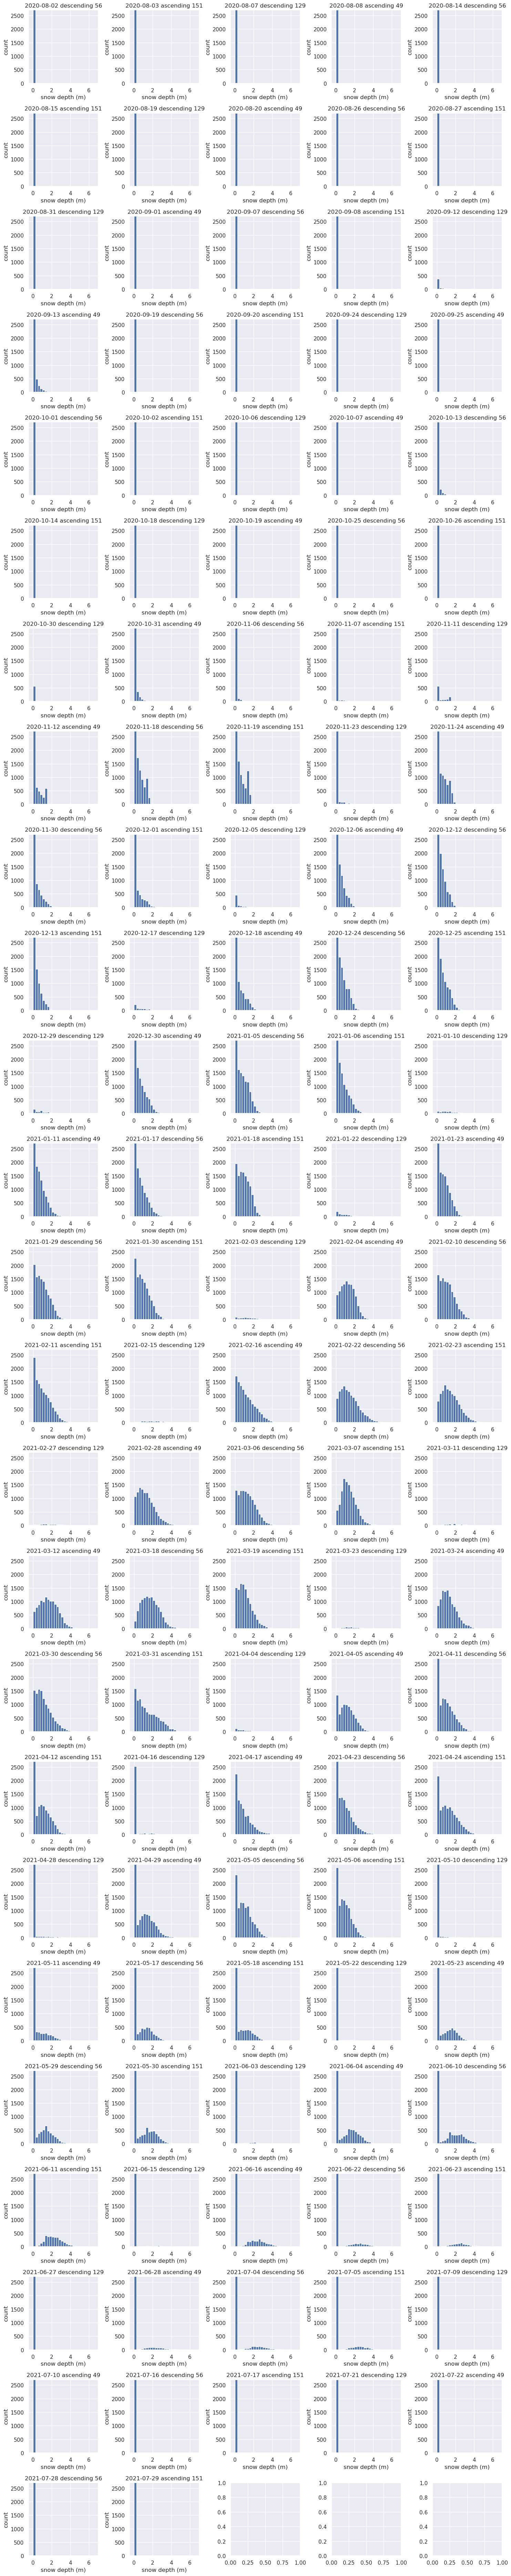

In [55]:
# plot snow depth distribution for all maps. This may take a minute
columns = 5
rows = math.ceil(len(sd_da.time)/columns)

f, ax = plt.subplots(rows, columns, figsize=(3*columns, 3*rows))
for i, time in enumerate(sd_da.time):
    row_num = math.floor(i/columns)
    col_num = i%columns
    
    ds.snow_depth.isel(time=i).plot.hist(ax=ax[row_num, col_num], bins=np.arange(0, 7, 0.25))
    ax[row_num, col_num].set_title(time.dt.strftime('%Y-%m-%d').item()+f' {time.flight_dir.item()} {int(time.relative_orbit.item())}')
    ax[row_num, col_num].set_xlabel('snow depth (m)')
    ax[row_num, col_num].set_ylabel('count')
    ax[row_num, col_num].set_xlim(-0.5, 7)
    ax[row_num, col_num].set_ylim(0, ds.snow_depth.max(dim='time').count(dim=['x', 'y'])/5)
    
f.tight_layout()

plt.savefig('./figs/sd_distributions.png', dpi=300)

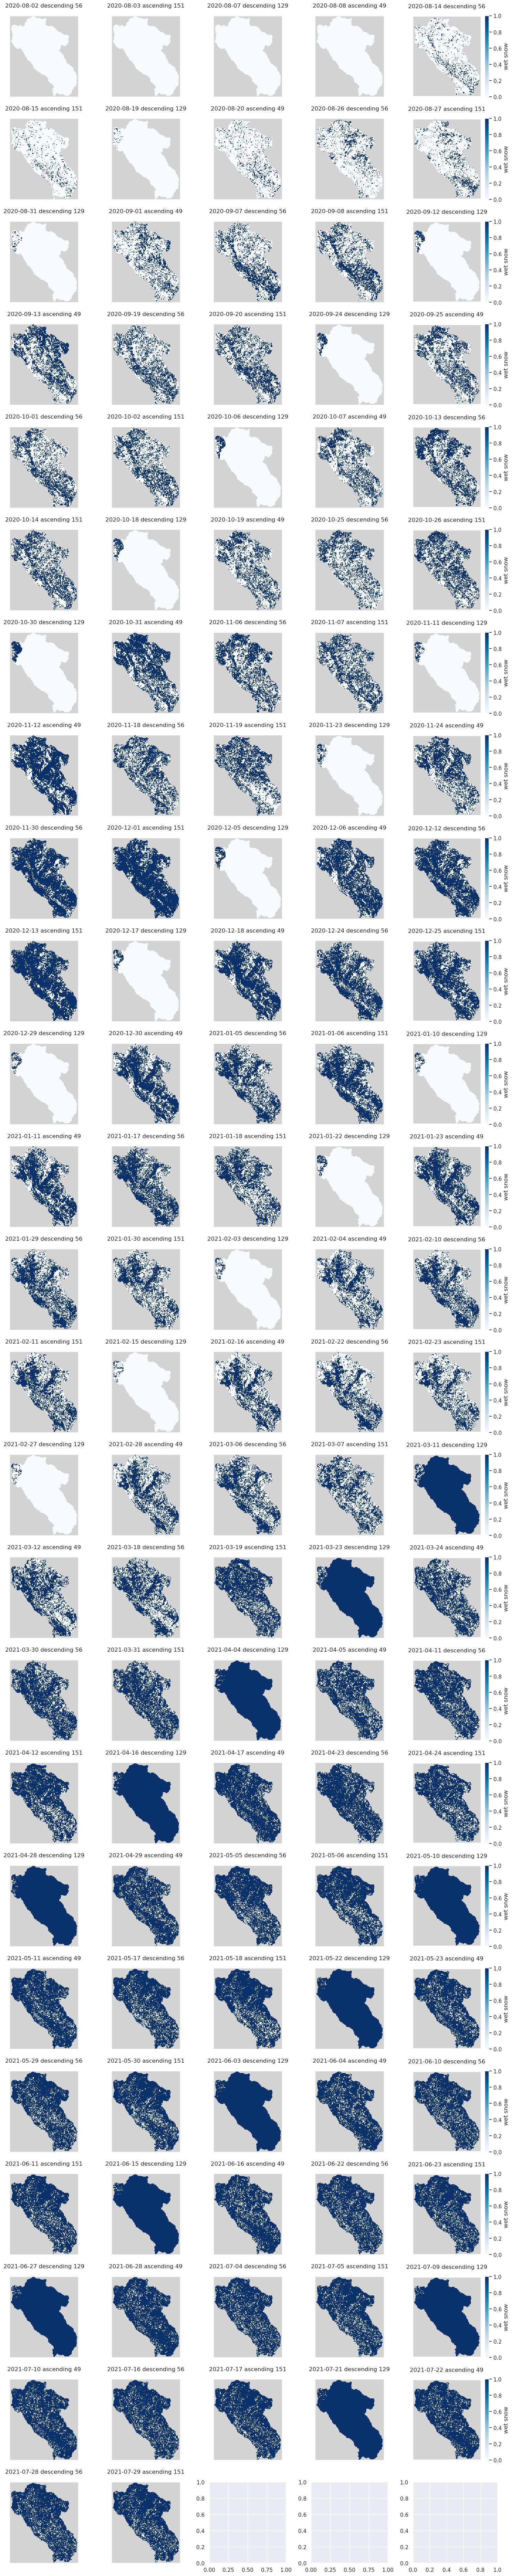

In [57]:
# plot all snow depth maps. This may take a minute
columns = 5
gridspec = {'width_ratios': [1, 1, 1, 1, 1.1]}
rows = math.ceil(len(ds.time)/columns)

f, ax = plt.subplots(rows, columns, figsize=(3*columns, 3*rows), gridspec_kw=gridspec)
for i, time in enumerate(ds.time):
    row_num = math.floor(i/columns)
    col_num = i%columns
    
    if col_num == columns-1:
        sd_map = ds.wet_snow.isel(time=i).plot(ax=ax[row_num, col_num], cmap='Blues', vmin=0, vmax=1, cbar_kwargs={'label':'wet snow'})
    else: 
        sd_map = ds.wet_snow.isel(time=i).plot(ax=ax[row_num, col_num], cmap='Blues', vmin=0, vmax=1, add_colorbar=False)
    ax[row_num, col_num].set_aspect('equal')
    ax[row_num, col_num].set_title(time.dt.strftime('%Y-%m-%d').item()+f' {time.flight_dir.item()} {int(time.relative_orbit.item())}')
    ax[row_num, col_num].axis('off')
    ax[row_num, col_num].add_patch(plt.Rectangle((0,0), 1, 1, facecolor='lightgray',
                                                 transform=ax[row_num, col_num].transAxes, zorder=-1))
    
f.tight_layout()

plt.savefig('./figs/wet_maps.png', dpi=300)